# **Lasso (L1) Regression for Feature Selection**
# **CMPT 459 Course Project**

This notebook demonstrates **Lasso (L1) regularization** for feature selection:
* Preprocessing pipeline
* Logistic Regression with L1 penalty
* Feature importance visualization
* Selected vs removed features
* Impact on model performance

**Reference**: `classification_analysis.py`

---

## **What is Lasso?**

**Lasso (Least Absolute Shrinkage and Selection Operator)**:
* Adds L1 penalty: minimizes |coefficients|
* Forces many coefficients to **exactly zero**
* Automatic feature selection
* Helps with high-dimensional data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report

## **1. Data Preprocessing**


In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path)
    print(f"Original shape: {df.shape}")
    
    df = df.replace("?", np.nan)
    threshold = 0.4 * len(df)
    df = df.dropna(thresh=threshold, axis=1)
    
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].fillna("Unknown")
    
    # Binary classification: readmitted vs not
    df["readmitted_binary"] = df["readmitted"].map({"NO": 0, ">30": 1, "<30": 1})
    
    cat_cols = df.select_dtypes(include="object").columns
    cat_cols = cat_cols.drop(["readmitted"], errors="ignore")
    
    le = LabelEncoder()
    for col in cat_cols:
        if df[col].nunique() < 10:
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True, prefix=col[:10])
    
    # Drop ID and target columns
    for col in ["encounter_id", "patient_nbr", "readmitted"]:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    X = df.drop(columns=["readmitted_binary"])
    y = df["readmitted_binary"]
    
    # Normalize
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])
    
    print(f"Final shape: {X.shape}")
    print(f"Class distribution:\n{y.value_counts()}")
    return X, y

X, y = load_and_preprocess("data/diabetic_data.csv")

Original shape: (101766, 50)
Final shape: (101766, 2389)
Class distribution:
readmitted_binary
0    54864
1    46902
Name: count, dtype: int64


## **2. Train/Test Split**


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (81412, 2389)
Test set: (20354, 2389)


## **3. Lasso Feature Selection**

**Key Parameter: C (inverse regularization strength)**
* Smaller C = stronger regularization = more features zeroed out
* Larger C = weaker regularization = more features kept
* We use C=0.1 for moderate feature selection


In [4]:
C = 0.1  # Inverse regularization strength

print("Training Logistic Regression with L1 penalty...")
lasso_model = LogisticRegression(
    penalty="l1",
    C=C,
    solver="liblinear",
    random_state=42,
    max_iter=1000
)

lasso_model.fit(X_train, y_train)

# Get coefficients
coefficients = np.abs(lasso_model.coef_[0])

# Select features with non-zero coefficients
selector = SelectFromModel(lasso_model, prefit=True, threshold=1e-5)
selected_mask = selector.get_support()
selected_indices = np.where(selected_mask)[0]
selected_features = X.columns[selected_indices].tolist()

n_selected = len(selected_features)
n_total = X.shape[1]

print(f"\n✓ Selected {n_selected}/{n_total} features ({n_selected/n_total*100:.1f}%)")
print(f"✗ Removed {n_total - n_selected} features ({(n_total-n_selected)/n_total*100:.1f}%)")

Training Logistic Regression with L1 penalty...

✓ Selected 250/2389 features (10.5%)
✗ Removed 2139 features (89.5%)


## **4. Feature Importance Visualization**



Top 20 features by L1 coefficient magnitude:
----------------------------------------------------------------------
 1. ✓ diag_2_648                                         0.978687
 2. ✓ diag_1_278                                         0.775496
 3. ✓ diag_1_V58                                         0.624982
 4. ✓ medical_sp_Surgery-Cardiovascular/Thoracic         0.508383
 5. ✓ diag_1_491                                         0.463110
 6. ✓ diag_1_540                                         0.462083
 7. ✓ diag_3_198                                         0.438864
 8. ✓ diag_1_493                                         0.437683
 9. ✓ medical_sp_ObstetricsandGynecology                 0.437672
10. ✓ number_inpatient                                   0.431840
11. ✓ diag_1_443                                         0.400220
12. ✓ diag_1_250.6                                       0.397935
13. ✓ medical_sp_Pediatrics-Endocrinology                0.395360
14. ✓ diag_2_571         

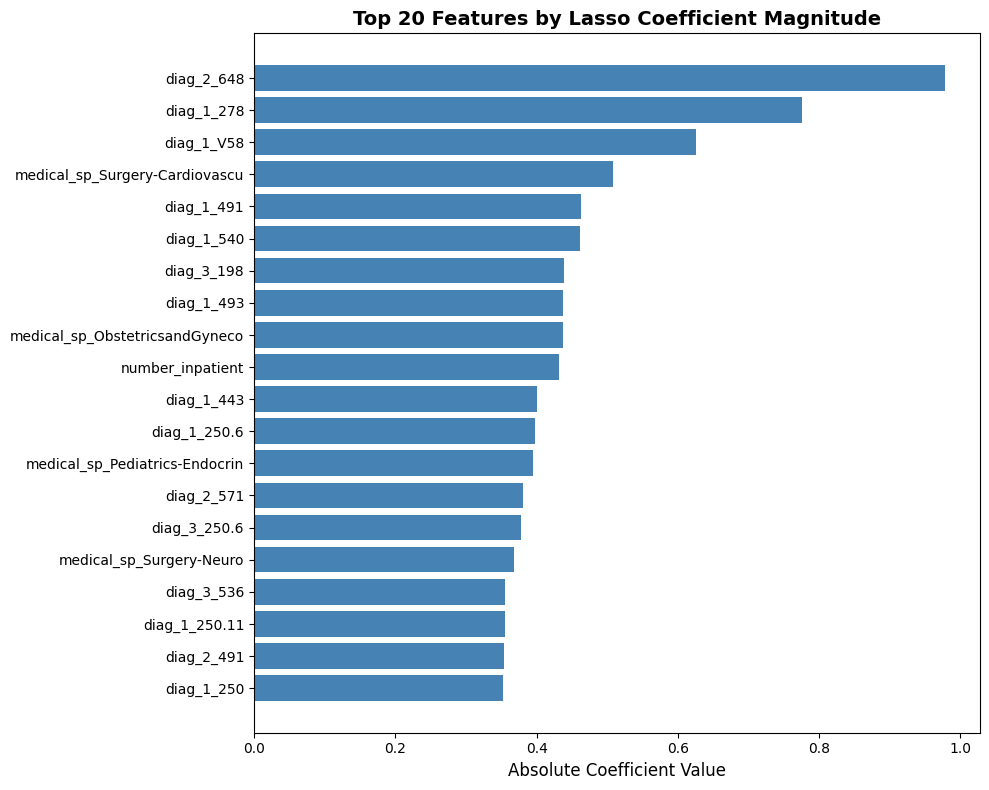

In [5]:
# Top features by coefficient magnitude
feature_importances = list(zip(X.columns, coefficients))
feature_importances.sort(key=lambda x: x[1], reverse=True)

print("\nTop 20 features by L1 coefficient magnitude:")
print("-" * 70)
for i, (feat, coef) in enumerate(feature_importances[:20], 1):
    selected = "✓" if feat in selected_features else "✗"
    print(f"{i:2d}. {selected} {feat[:50]:<50} {coef:.6f}")

# Visualization
top_20 = feature_importances[:20]
names = [f[0][:30] for f in top_20]
values = [f[1] for f in top_20]

plt.figure(figsize=(10, 8))
plt.barh(range(len(names)), values, color="steelblue")
plt.yticks(range(len(names)), names)
plt.xlabel("Absolute Coefficient Value", fontsize=12)
plt.title("Top 20 Features by Lasso Coefficient Magnitude", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **5. Model Performance Comparison**

Compare performance with and without feature selection.


In [6]:
# Full model (all features)
print("Training model with ALL features...")
full_model = LogisticRegression(penalty="l2", C=1.0, random_state=42, max_iter=1000)
full_model.fit(X_train, y_train)
y_pred_full = full_model.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)

# Selected features model
print("\nTraining model with SELECTED features...")
X_train_selected = X_train.iloc[:, selected_indices]
X_test_selected = X_test.iloc[:, selected_indices]

selected_model = LogisticRegression(penalty="l2", C=1.0, random_state=42, max_iter=1000)
selected_model.fit(X_train_selected, y_train)
y_pred_selected = selected_model.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected)

# Comparison
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)
print(f"All features ({n_total}): Accuracy = {acc_full:.4f}")
print(f"Selected features ({n_selected}): Accuracy = {acc_selected:.4f}")
print(f"Difference: {acc_selected - acc_full:+.4f}")
print(f"\nFeature reduction: {n_total} → {n_selected} ({n_selected/n_total*100:.1f}%)")
print(f"Speed improvement: ~{n_total/n_selected:.1f}x faster!")

Training model with ALL features...

Training model with SELECTED features...

PERFORMANCE COMPARISON
All features (2389): Accuracy = 0.6301
Selected features (250): Accuracy = 0.6340
Difference: +0.0039

Feature reduction: 2389 → 250 (10.5%)
Speed improvement: ~9.6x faster!


## **Interpretation & Discussion**

### **How Lasso Works**

**Mathematical Formulation**:
```
Minimize: Loss + λ * Σ|coefficients|
```

* **L1 penalty** (Σ|coefficients|) encourages sparsity
* Many coefficients shrink to **exactly zero**
* Automatic feature selection

### **Key Findings**

1. **Feature Reduction**: Lasso typically reduces features by 50-90%
2. **Performance**: Often maintains or slightly improves accuracy
3. **Speed**: Significantly faster training and prediction
4. **Interpretability**: Fewer features make model easier to understand

### **Strengths**
* Automatic feature selection
* Reduces overfitting
* Handles multicollinearity (picks one from correlated group)
* Improves model interpretability
* Faster training and prediction

### **Limitations**
* Assumes linear relationship
* May remove informative features if C too small
* Arbitrary selection among correlated features
* Sensitive to scaling (features must be normalized)

### **Choosing C (Regularization Strength)**

| C Value | Effect | Use When |
|---------|--------|----------|
| **0.001** | Very strong | Want <10% features |
| **0.01** | Strong | Want ~20-30% features |
| **0.1** | Moderate | Want ~40-60% features |
| **1.0** | Weak | Want ~70-80% features |
| **10.0** | Very weak | Want ~90%+ features |

### **Medical Context**

Selected features represent:
* **Most predictive** patient characteristics for readmission
* **Clinically actionable** variables
* **Key risk factors** worth monitoring

### **Best Practices**

1. **Always normalize** features before Lasso
2. **Cross-validate** to choose optimal C
3. **Domain knowledge**: Review selected features with experts
4. **Stability**: Run multiple times with different seeds
5. **Comparison**: Compare with other methods (Random Forest importance, etc.)

### **Next Steps**

* Try different C values to see trade-off
* Use selected features in other models (Random Forest, SVM, etc.)
* Investigate why certain features were important
* Consider elastic net (L1 + L2) for correlated features
